In [13]:
# I want to predict the price of houses in King county, which includes Seattle.

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')
import scipy
import sklearn
from sklearn.model_selection import cross_val_score
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std

# Suppress annoying harmless error.
import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [15]:
# Upload the data into Jupyter Notebook
df = pd.read_csv('/Users/cappsjr/Downloads/kc_house_data.csv')

# Take a quick peak at the data
df.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639


In [16]:
# What are the column data types
df.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [17]:
# How many features are there?
print(len(df.columns))

# How many rows are there?
print(len(df))

21
21613


In [18]:
# Check the features for NaN values
columns = list(df.columns)
for item in columns:
    print(df[item].isnull().sum())

# This data is super clean

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


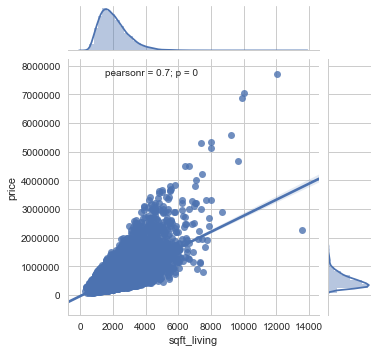

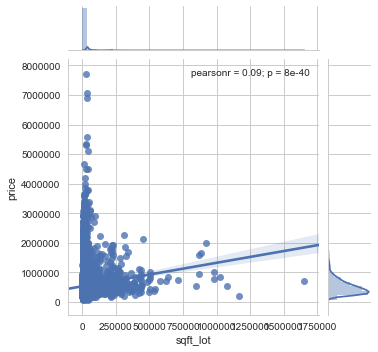

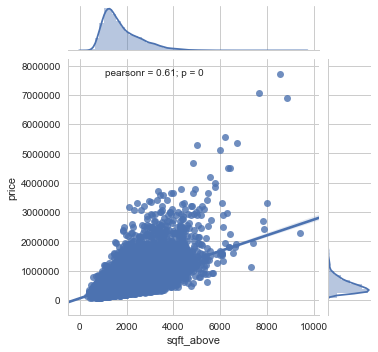

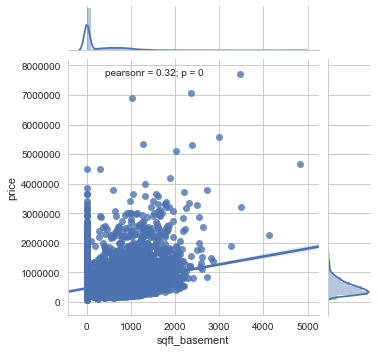

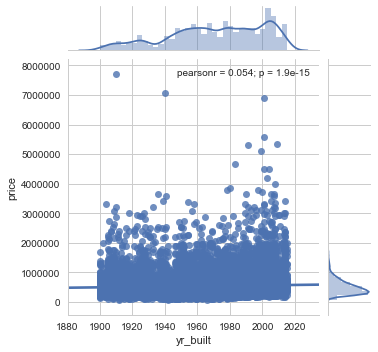

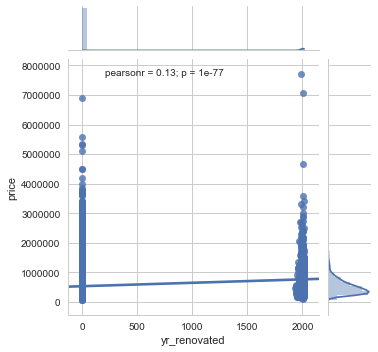

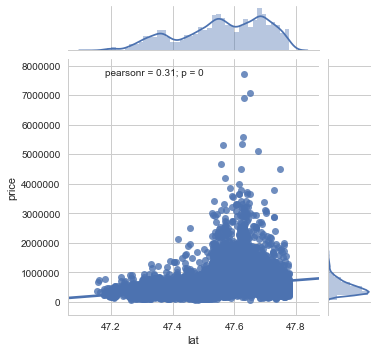

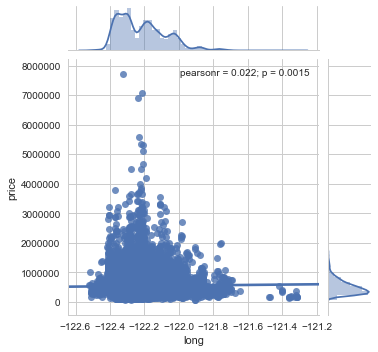

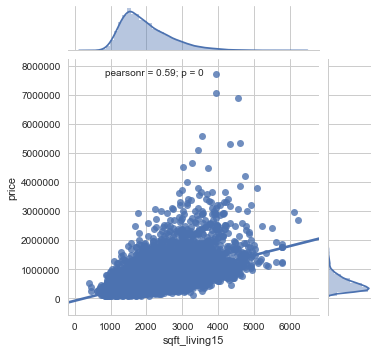

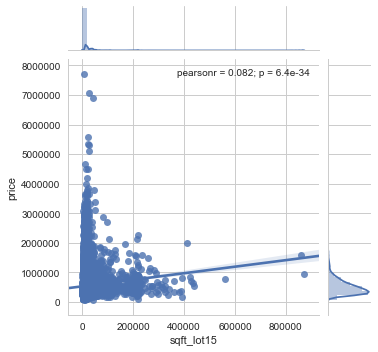

In [19]:
# Lets take a look at the relationship between some of the continuous variables and my target variable (price)

cont_var = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long', 'sqft_living15', 'sqft_lot15']

for items in cont_var:
    sns.jointplot(x=items, y='price', data=df, kind='reg', size=5)

In [20]:
# Lets make new categorical variables showing whether each house 1) has a basement; 2) was renovated.
df['has_basement'] = np.where(df['sqft_basement'] > 0, 1, 0)
df['was_renovated'] = np.where(df['yr_renovated'] > 0, 1, 0)

df.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,has_basement,was_renovated
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,0,1955,0,98178,47.5112,-122.257,1340,5650,0,0
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,1,1


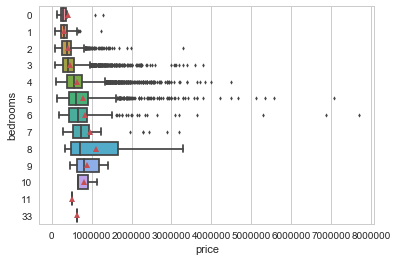

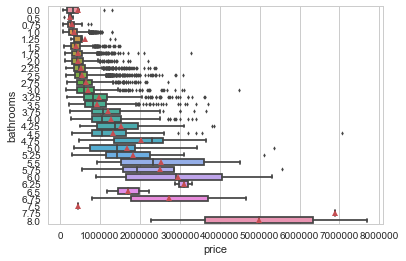

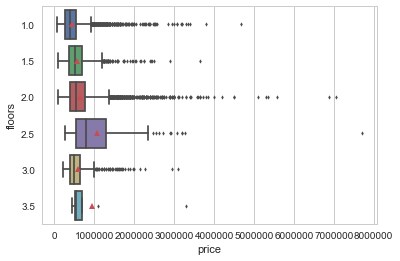

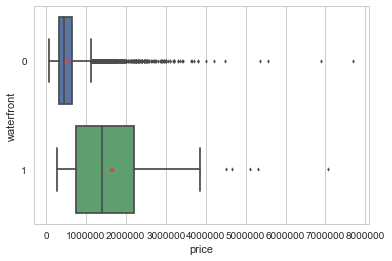

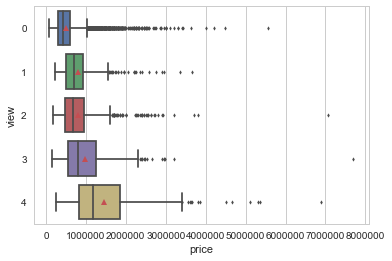

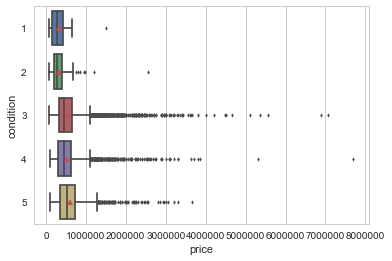

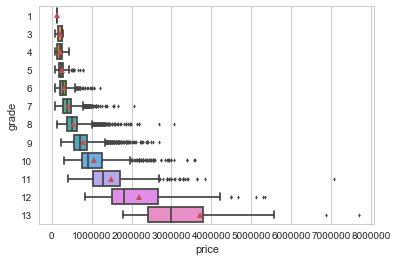

In [21]:
# Now lets take a look at relationship between the categorical variables and my target variable.
cat_var = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']

for items in cat_var:
    sns.boxplot(y=items, x='price', orient='h', data=df, showmeans=True, fliersize=3)
    plt.show()
    
# This is sort of difficult to make out.  Lets redo these one at a time.

In [22]:
# Lets do a simple linear regression for each of the predictor variables to the target variable.

from sklearn import linear_model

# Lets look at the number of unique values in each of the categorical variables before we convert them to dummies.
for items in cat_var:
    print(len(df[items].unique()))

13
30
6
2
5
5
12


In [23]:
# There are a lot of unique values in features bedroom, bathroom, and grade. 
# Perhaps we should treat these as continuous variables because creating dummy variables will add too many
# new features to the dataset.  Lets turn the others into dummies though.
df_dum = pd.get_dummies(df[['floors', 'waterfront', 'view', 'condition']])

# Join the dummies to the DataFrame
df = df.drop(['floors', 'waterfront', 'view', 'condition'], axis=1)
df = pd.concat([df, df_dum], axis=1)
df.head(2)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,grade,sqft_above,sqft_basement,...,lat,long,sqft_living15,sqft_lot15,has_basement,was_renovated,floors,waterfront,view,condition
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,7,1180,0,...,47.5112,-122.257,1340,5650,0,0,1.0,0,0,3
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,7,2170,400,...,47.7210,-122.319,1690,7639,1,1,2.0,0,0,3


In [24]:
# Lets create a function that will create a simple linear regression for a training and test set

rvalues = []

def simple_linear_reg(X, y):
    # Make the model
    X = X.reshape(-1, 1)
    regr = linear_model.LinearRegression() # Instantiate the model
    regr_fit = regr.fit(X, y) # Fit the model 
    pred = regr.predict(X) # Prediction
    score = regr.score(X, y)
    rvalues.append(score)
    # Make the visuals
    plt.scatter(X, y, color='black')
    plt.plot(X, pred)
    plt.show()
    print('Coef: \n', regr.coef_)
    print('Intercept: \n', regr.intercept_)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  import sys


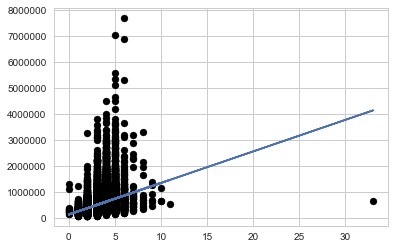

Coef: 
 [ 121716.12651184]
Intercept: 
 129802.356318


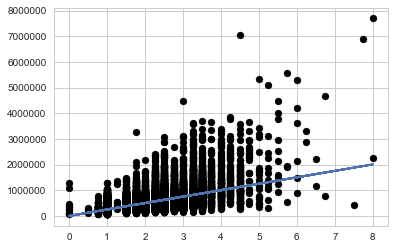

Coef: 
 [ 250326.5163021]
Intercept: 
 10708.3085304


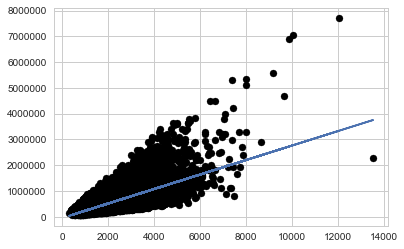

Coef: 
 [ 280.6235679]
Intercept: 
 -43580.7430945


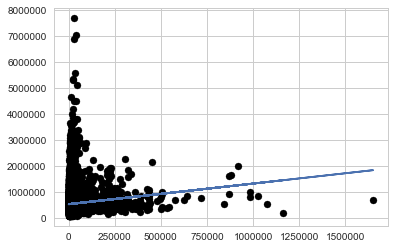

Coef: 
 [ 0.79470145]
Intercept: 
 528082.612802


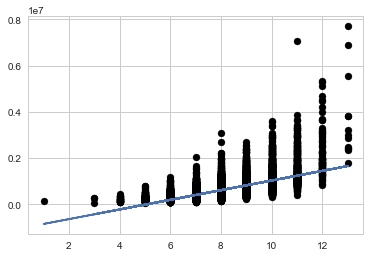

Coef: 
 [ 208457.56245839]
Intercept: 
 -1056044.97701


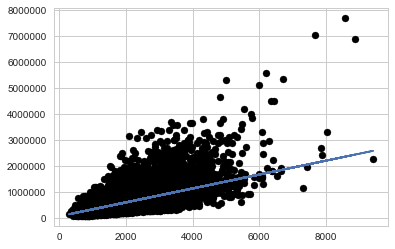

Coef: 
 [ 268.47318776]
Intercept: 
 59953.192047


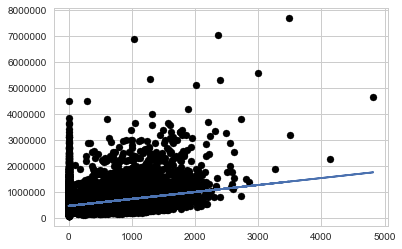

Coef: 
 [ 268.61358277]
Intercept: 
 461784.852648


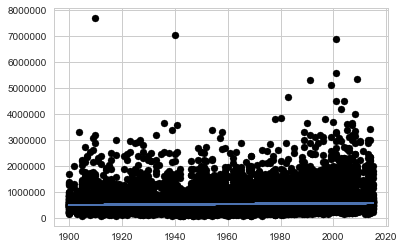

Coef: 
 [ 675.06978569]
Intercept: 
 -790477.872855


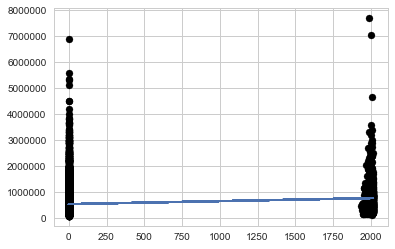

Coef: 
 [ 115.55808591]
Intercept: 
 530334.778397


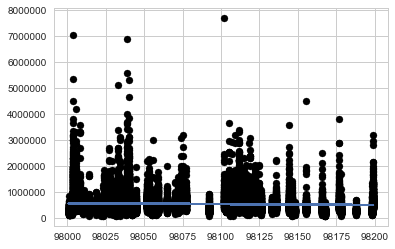

Coef: 
 [-365.0538297]
Intercept: 
 36343815.6765


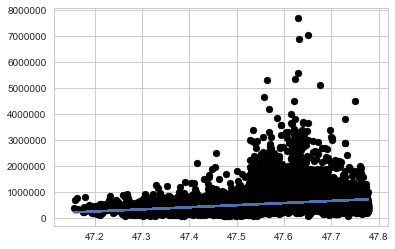

Coef: 
 [ 813411.5831937]
Intercept: 
 -38145809.4747


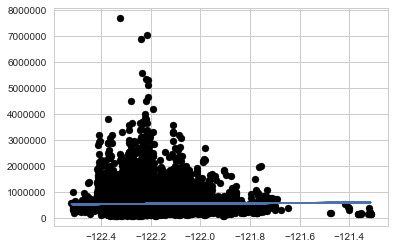

Coef: 
 [ 56377.72275781]
Intercept: 
 7430229.31044


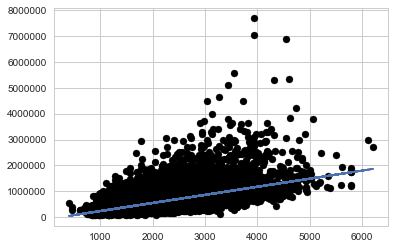

Coef: 
 [ 313.55594157]
Intercept: 
 -82807.1952085


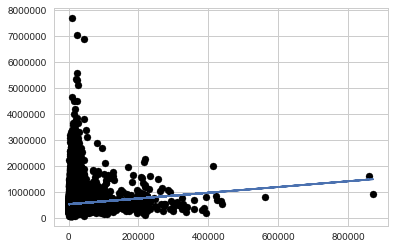

Coef: 
 [ 1.10856991]
Intercept: 
 525933.416031


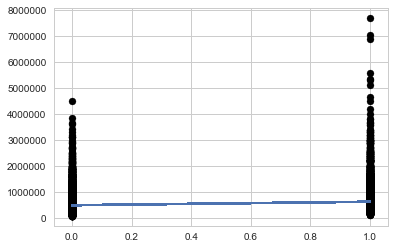

Coef: 
 [ 135489.47329607]
Intercept: 
 486884.090507


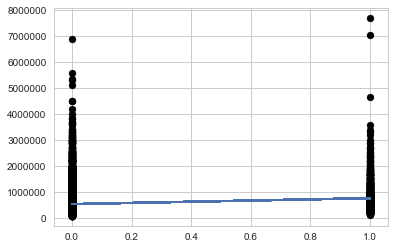

Coef: 
 [ 230018.21138503]
Intercept: 
 530360.818155


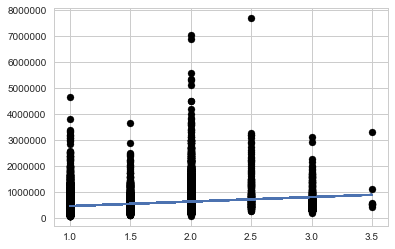

Coef: 
 [ 174588.81258204]
Intercept: 
 279198.511194


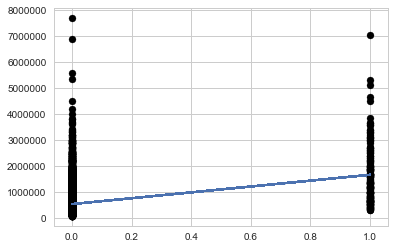

Coef: 
 [ 1130312.42472639]
Intercept: 
 531563.599814


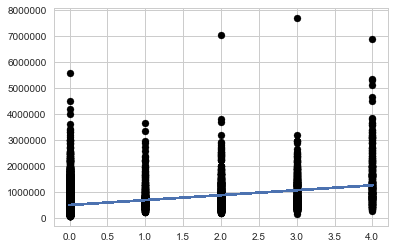

Coef: 
 [ 190335.24792684]
Intercept: 
 495491.940614


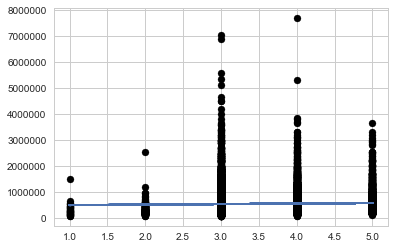

Coef: 
 [ 20514.09043334]
Intercept: 
 470146.796472


In [25]:
slr_pred_var = df.drop(['price', 'id', 'date'], axis=1)
df_bestfit= pd.DataFrame()
for items in list(slr_pred_var):
    simple_linear_reg(df[items], df['price'])

    # This is difficult to look through.  Lets do them one at a time.

In [26]:
# Lets make a DataFrame with features sorted by rvalues
df_bestfit = pd.DataFrame()
df_bestfit['features'] = slr_pred_var.columns
df_bestfit['rvalues'] = rvalues

df_bestfit = df_bestfit.sort_values('rvalues', ascending=False)
df_bestfit.head(10)
# This shows the top 10 features for predicting price with a simple linear regression with their associated r-values.

,features,rvalues
2,sqft_living,0.492853
4,grade,0.445468
5,sqft_above,0.366712
12,sqft_living15,0.342668
1,bathrooms,0.275769
18,view,0.157842
6,sqft_basement,0.104857
0,bedrooms,0.095079
10,lat,0.094251
17,waterfront,0.070953


In [27]:
# Now lets build a multiple regression
# We will start with all the predictor variables, and then evaluate and eliminate those that are not contributing.

# Lets make another function, but this time for a multiple regression.
from sklearn.preprocessing import StandardScaler

def multiple_reg(X, y):
    X = StandardScaler().fit_transform(X)
    regr = linear_model.LinearRegression() # Instantiate the model
    regr_fit = regr.fit(X, y) # Fit the model 
    pred = regr.predict(X) # Prediction
    score = regr.score(X, y)
    print('Multiple Reg Coefficients: \n', regr.coef_)
    print('\nMultiple Reg Intercept: \n', regr.intercept_)

In [28]:
# Define the predictor variables we'll use in our multiple linear reg function.
mult_reg_var = df.drop(['price', 'id', 'date'], axis=1)

multiple_reg(mult_reg_var, df['price'])

Multiple Reg Coefficients: 
 [ -3.39002807e+04   3.12946266e+04   1.16249370e+17   5.51255889e+03
   1.11784688e+05  -1.04813554e+17  -5.60178344e+16  -7.69337272e+04
   1.43203703e+06  -3.12320000e+04   8.36880000e+04  -3.04320000e+04
   1.54320000e+04  -1.05120000e+04  -2.02000000e+03  -1.42408000e+06
   3.95550000e+03   5.09420000e+04   4.06240000e+04   1.78560000e+04]

Multiple Reg Intercept: 
 540075.421999


In [29]:
# Lets evaluate the model using statsmodel
import statsmodels.api as sm

# fit a OLS model with intercepts on population, population**2, murder, and robbery
X = sm.add_constant(mult_reg_var)
est = sm.OLS(df['price'], X).fit()

est.summary()

/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2661.
Date:                Mon, 25 Sep 2017   Prob (F-statistic):               0.00
Time:                        15:05:28   Log-Likelihood:            -2.9457e+05
No. Observations:               21613   AIC:                         5.892e+05
Df Residuals:                   21593   BIC:                         5.893e+05
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.573e+06   2.94e+06      2.233      0.026    8.04e+05    1.23e+07
bedrooms      -3.599e+04   1889.214    -19.052      0.000   -3.97e+04   -3.23e+04
bathrooms      4.045e+04   3278.010     12.341      0.000     3.4e+04    4.69e+04
sqft_living     111.4028      2.542     43.829      0.000     106.421     116.385
sqft_lot          0.1337      0.048      2.793      0.005       0.040       0.227
grade          9.516e+04   2159.736     44.059      0.000    9.09e+04    9.94e+04
sqft_above       69.9279      3.036     23.032      0.000      63.977      75.879
sqft_basement    41.4804      4.141     10.016      0.000      33.363      49.598
yr_built      -2620.2147     72.575    -36.104      0.000   -2762.466   -2477.963
yr_renovated   3562.7868    432.049      8.246      0.000    2715.938    4409.635
zipcode        -583.3755     32.986    -17.686      0.000    -648.030    -518.721
lat            6.039e+05   1.07e+04     56.293      0.000    5.83e+05    6.25e+05
long           -2.16e+05   1.31e+04    -16.429      0.000   -2.42e+05    -1.9e+05
sqft_living15    22.5236      3.445      6.539      0.000      15.772      29.275
sqft_lot15       -0.3860      0.073     -5.276      0.000      -0.529      -0.243
has_basement  -4102.8455   5257.920     -0.780      0.435   -1.44e+04    6203.066
was_renovated -7.072e+06   8.62e+05     -8.201      0.000   -8.76e+06   -5.38e+06
floors         7328.7182   3592.168      2.040      0.041     287.803    1.44e+04
waterfront     5.892e+05   1.74e+04     33.951      0.000    5.55e+05    6.23e+05
view           5.302e+04   2139.165     24.784      0.000    4.88e+04    5.72e+04
condition      2.743e+04   2354.426     11.650      0.000    2.28e+04     3.2e+04
==============================================================================
Omnibus:                    18428.996   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1894852.436
Skew:                           3.577   Prob(JB):                         0.00
Kurtosis:                      48.310   Cond. No.                     1.76e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.1e-19. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [30]:
# Now lets evaluate the individual parameters using linear_formula
# Write out the model formula
linear_formula = 'price ~ bedrooms+bathrooms+sqft_living+sqft_lot+grade+sqft_above+sqft_basement+yr_built+yr_renovated+zipcode+lat+long+sqft_living15+has_basement+was_renovated+floors+waterfront+view+condition'

# Fit our model to the data using the formula
lm = smf.ols(formula=linear_formula, data=df).fit()

# Evaluate
print('Coefficients: \n', lm.params)
print('\nP-values: \n', lm.pvalues)
print('\nR-squared: \n', lm.rsquared)
print('\nConfidence Intervals: \n', lm.conf_int())

Coefficients: 
 Intercept        5.974451e+06
bedrooms        -3.553931e+04
bathrooms        4.090861e+04
sqft_living      1.108143e+02
sqft_lot        -4.019967e-02
grade            9.545673e+04
sqft_above       6.948124e+01
sqft_basement    4.133534e+01
yr_built        -2.625856e+03
yr_renovated     3.550667e+03
zipcode         -5.848270e+02
lat              6.051574e+05
long            -2.216618e+05
sqft_living15    2.161535e+01
has_basement    -4.016284e+03
was_renovated   -7.047880e+06
floors           7.991574e+03
waterfront       5.881019e+05
view             5.296949e+04
condition        2.721304e+04
dtype: float64

P-values: 
 Intercept         4.236862e-02
bedrooms          2.214277e-78
bathrooms         1.334613e-35
sqft_living       0.000000e+00
sqft_lot          2.469391e-01
grade             0.000000e+00
sqft_above       1.703559e-114
sqft_basement     2.196690e-23
yr_built         4.428550e-278
yr_renovated      2.273242e-16
zipcode           9.264404e-70
lat            

In [31]:
# Redefine the predictor variables we'll use in our multiple linear reg function.
# Lets drop sqft_lot and has_basement because they have p-values of greater than .05
mult_reg_var2 = df.drop(['price', 'id', 'date', 'sqft_lot', 'has_basement'], axis=1)

# Run the model
multiple_reg(mult_reg_var2, df['price'])

Multiple Reg Coefficients: 
 [ -3.43385672e+04   3.12238329e+04   2.11506756e+17   1.11921619e+05
  -1.90700171e+17  -1.01920126e+17  -7.71970628e+04   1.42721985e+06
  -3.12946642e+04   8.34720000e+04  -2.99840000e+04   1.49920000e+04
  -6.72000000e+03  -1.41934400e+06   3.91600000e+03   5.08800000e+04
   4.08640000e+04   1.78080000e+04]

Multiple Reg Intercept: 
 540064.999131


In [32]:
# Use stats models to get information on how the model worked
import statsmodels.api as sm

# fit a OLS model with intercepts on population, population**2, murder, and robbery
X = sm.add_constant(mult_reg_var2)
est = sm.OLS(df['price'], X).fit()

est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     2972.
Date:                Mon, 25 Sep 2017   Prob (F-statistic):               0.00
Time:                        15:05:28   Log-Likelihood:            -2.9457e+05
No. Observations:               21613   AIC:                         5.892e+05
Df Residuals:                   21595   BIC:                         5.893e+05
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          7.171e+06   2.92e+06      2.452      0.014    1.44e+06    1.29e+07
bedrooms      -3.612e+04   1888.755    -19.123      0.000   -3.98e+04   -3.24e+04
bathrooms      4.021e+04   3251.397     12.368      0.000    3.38e+04    4.66e+04
sqft_living     110.8007      2.264     48.940      0.000     106.363     115.238
grade          9.514e+04   2152.004     44.209      0.000    9.09e+04    9.94e+04
sqft_above       71.8502      2.249     31.950      0.000      67.442      76.258
sqft_basement    38.9522      2.644     14.732      0.000      33.770      44.135
yr_built      -2627.5336     72.490    -36.247      0.000   -2769.619   -2485.448
yr_renovated   3554.6090    431.999      8.228      0.000    2707.858    4401.360
zipcode        -584.6382     32.941    -17.748      0.000    -649.206    -520.070
lat            6.025e+05   1.07e+04     56.236      0.000    5.82e+05    6.24e+05
long          -2.128e+05   1.31e+04    -16.262      0.000   -2.38e+05   -1.87e+05
sqft_living15    21.8344      3.437      6.353      0.000      15.098      28.571
sqft_lot15       -0.2454      0.053     -4.625      0.000      -0.349      -0.141
was_renovated -7.055e+06   8.62e+05     -8.183      0.000   -8.75e+06   -5.37e+06
floors         7164.7102   3591.009      1.995      0.046     126.068    1.42e+04
waterfront     5.885e+05   1.74e+04     33.919      0.000    5.55e+05    6.23e+05
view           5.329e+04   2136.049     24.950      0.000    4.91e+04    5.75e+04
condition      2.739e+04   2351.784     11.645      0.000    2.28e+04     3.2e+04
==============================================================================
Omnibus:                    18419.981   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1888713.217
Skew:                           3.575   Prob(JB):                         0.00
Kurtosis:                      48.235   Cond. No.                     1.72e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.19e-19. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [33]:
# The p-values for sqft_lot and has_basement are greater than .05
# This suggests that eliminating them from the model will not adversely affect the r-squared value.

# Write out the model formula
linear_formula = 'price ~ bedrooms+bathrooms+sqft_living+grade+sqft_above+sqft_basement+yr_built+yr_renovated+zipcode+lat+long+sqft_living15+was_renovated+floors+waterfront+view+condition'

# Fit our model to the data using the formula
lm = smf.ols(formula=linear_formula, data=df).fit()

# Evaluate
print('Coefficients: \n', lm.params)
print('\nP-values: \n', lm.pvalues)
print('\nR-squared: \n', lm.rsquared)
print('\nConfidence Intervals: \n', lm.conf_int())

Coefficients: 
 Intercept        5.879579e+06
bedrooms        -3.535090e+04
bathrooms        4.063493e+04
sqft_living      1.096467e+02
grade            9.531084e+04
sqft_above       7.074264e+01
sqft_basement    3.890288e+01
yr_built        -2.620459e+03
yr_renovated     3.563001e+03
zipcode         -5.865751e+02
lat              6.056925e+05
long            -2.235348e+05
sqft_living15    2.173333e+01
was_renovated   -7.072311e+06
floors           8.316483e+03
waterfront       5.885850e+05
view             5.291738e+04
condition        2.732473e+04
dtype: float64

P-values: 
 Intercept         4.354062e-02
bedrooms          4.591438e-78
bathrooms         1.034348e-35
sqft_living       0.000000e+00
grade             0.000000e+00
sqft_above       1.461174e-214
sqft_basement     1.002887e-48
yr_built         9.558489e-278
yr_renovated      1.761239e-16
zipcode           2.265582e-70
lat               0.000000e+00
long              5.660590e-67
sqft_living15     2.652702e-10
was_renovated

In [34]:
# Lets try a partial least square regression and see how a reduction in dimensionality will affect the model.
from sklearn.cross_decomposition import PLSRegression

# Lets create another function for PLSR

def par_lsr(X, y, k):
    
    plsr = PLSRegression(n_components= k) # Intantiate the model
    plsr_fit = plsr.fit(X, y) # Fit the model
    plsr_pred = plsr.predict(X) # Make predictions
    plsr_score = plsr.score(X, y) # Obtain the score
    print('PLSR R-Squared: \n', plsr_score) # Print the r-squared value 

In [35]:
# Define the predictor variables to be used in the PLSR model
plsr_var = df.drop(['price', 'id', 'date'], axis=1)

# Lets run the model with the top 5 features and see how it goes.
par_lsr(plsr_var, df['price'], 5)

PLSR R-Squared: 
 -4.23861756505


In [36]:
# Lets try the model with the top 10 features and see how it goes.
par_lsr(plsr_var, df['price'], 10)

PLSR R-Squared: 
 -3.94568581399


In [37]:
# Lets try the model with the top 15 features and see how it goes.
par_lsr(plsr_var, df['price'], 15)

PLSR R-Squared: 
 -3.95867605538


In [38]:
# Lets try a stochastic gradient descent regressor to see if this model is sufficiently complex to require
# this iterative process as opposed to plain old OLS.

from sklearn import linear_model

# Lets create another function for our stochastic gradient descent regressor
def sgd_reg(X, y, pen, cvk):
    X = StandardScaler().fit_transform(X)
    sgd = linear_model.SGDRegressor(penalty=pen, learning_rate='optimal')
    sgd_fit = sgd.fit(X, y)
    sgd_pred = sgd.predict(X)
    sgd_score = sgd.score(X, y)
    print('R-square SGD: \n', sgd_score)
    sgd_crossval = cross_val_score(sgd, X, y, cv=cvk)
    print('\nSGD Cross-Validation R-Squared: \n', sgd_crossval)
    print('\nMean Accuracy: %0.2f (+/- %0.2f)' % (sgd_crossval.mean(), sgd_crossval.std() * 2))

In [39]:
sgd_var = df.drop(['price', 'id', 'date'], axis=1)

sgd_reg(sgd_var, df['price'], 'l1', 5)

R-square SGD: 
 -7.23623295638e+12

SGD Cross-Validation R-Squared: 
 [ -9.37936723e+12  -1.77644303e+13  -8.44596596e+12  -3.00303456e+13
  -1.09216581e+13]

Mean Accuracy: -15308353450289.14 (+/- 16106090844818.02)


In [40]:
sgd_var = df.drop(['price', 'id', 'date'], axis=1)

sgd_reg(sgd_var, df['price'], 'l2', 5)

R-square SGD: 
 -6.37386322493e+12

SGD Cross-Validation R-Squared: 
 [ -1.09766708e+13  -7.96595420e+12  -1.10665413e+13  -2.69785084e+13
  -8.21096747e+12]

Mean Accuracy: -13039728448886.98 (+/- 14184481092712.96)


In [41]:
# Lets run a KNN Regression

from sklearn import neighbors
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

# Lets create another function
def knn_reg_unweighted(X, y, k, cvk):
    X = StandardScaler().fit_transform(X)
    knn = neighbors.KNeighborsRegressor(n_neighbors=k) # Instantiate the model
    knn_fit = knn.fit(X, y) # Fit the model
    knn_predict = knn.predict(X) # Make predictions
    knn_score = knn.score(X, y)
    print('\nR-squared Unweighted KNN: \n', knn_score)
    knn_crossval = cross_val_score(knn, X, y, cv=cvk)
    print('\nUnweighted Accuracy: %0.2f (+/- %0.2f)' % (knn_crossval.mean(), knn_crossval.std() * 2))


In [42]:
# Lets define our predictor variables and run the model
knn_var = df.drop(['price', 'id', 'date'], axis=1)

knn_reg_unweighted(knn_var, df['price'], 10, 5)


R-squared Unweighted KNN: 
 0.835021441375

Unweighted Accuracy: 0.79 (+/- 0.04)


In [43]:
# Lets make another function, but this time lets weight the observations by distance
def knn_reg_weighted(X, y, k, cvk):
    X = StandardScaler().fit_transform(X)
    knn = neighbors.KNeighborsRegressor(n_neighbors=k, weights='distance') # Instantiate the model
    knn_fit = knn.fit(X, y) # Fit the model
    knn_predict = knn.predict(X) # Make predictions
    knn_score = knn.score(X, y)
    print('\nR-squared Weighted KNN: \n', knn_score)
    knn_crossval = cross_val_score(knn, X, y, cv=cvk)
    print('\nWeighted Accuracy: %0.2f (+/- %0.2f)' % (knn_crossval.mean(), knn_crossval.std() * 2))

knn_reg_weighted(knn_var, df['price'], 10, 5)


R-squared Weighted KNN: 
 0.999133829054

Weighted Accuracy: 0.79 (+/- 0.04)


In [44]:
# Lets change the number of neighbors (k) to 5 for both the weighted and unweighted models.
knn_reg_unweighted(knn_var, df['price'], 5, 5)

knn_reg_weighted(knn_var, df['price'], 5, 5)


R-squared Unweighted KNN: 
 0.871915193028

Unweighted Accuracy: 0.78 (+/- 0.04)

R-squared Weighted KNN: 
 0.999133829054

Weighted Accuracy: 0.79 (+/- 0.04)


In [45]:
# Lets try increasing k to 15 instead and see what happens.
knn_reg_unweighted(knn_var, df['price'], 15, 5)

knn_reg_weighted(knn_var, df['price'], 15, 5)


R-squared Unweighted KNN: 
 0.81671230289

Unweighted Accuracy: 0.78 (+/- 0.03)

R-squared Weighted KNN: 
 0.999133829054

Weighted Accuracy: 0.79 (+/- 0.03)


In [46]:
# Now lets try a random forest and see how that works

from sklearn import ensemble

# Lets create a function for our random forest model.
def ranfor_reg(X, y, n_est, max_dep, cvk):
    rfr = ensemble.RandomForestRegressor(n_estimators=n_est, max_depth=max_dep)
    rfr_fit = rfr.fit(X, y)
    rfr_predict = rfr.predict(X)
    rfr_score = rfr.score(X,y)
    print('\nR-squared Random Forest: \n', rfr_score)
    rfr_crossval = cross_val_score(rfr, X, y, cv=cvk)
    print('\nCross Validated Accuracy: \n', rfr_crossval)
    print('\n Mean Accuracy: %0.2f (+/- %0.2f)' % (rfr_crossval.mean(), rfr_crossval.std() * 2))
    # Make importances relative to max importance
    feature_importance = rfr.feature_importances_
    feature_importance = 100 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) +  0.5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative importance')
    plt.ylabel('Variable importance')
    plt.show()


R-squared Random Forest: 
 0.542327608535

Cross Validated Accuracy: 
 [ 0.51320436  0.48529223  0.55884626  0.56061944  0.5213916 ]

 Mean Accuracy: 0.53 (+/- 0.06)


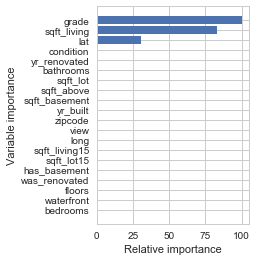

In [47]:
# First define the arguments for the function then run the model.
rfr_var = df.drop(['price', 'id', 'date'], axis=1)

ranfor_reg(rfr_var, df['price'], 10, 2, 5)


R-squared Random Forest: 
 0.53968901217

Cross Validated Accuracy: 
 [ 0.53405741  0.51843764  0.55527885  0.56285213  0.53254859]

 Mean Accuracy: 0.54 (+/- 0.03)


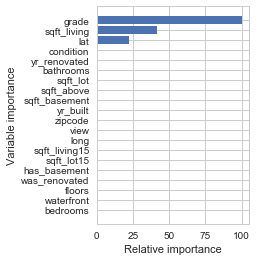

In [48]:
# Lets increase the number of iterations/"trees in the forest" (n_estimators) to 100.
ranfor_reg(rfr_var, df['price'], 100, 2, 5)


R-squared Random Forest: 
 0.983603978004

Cross Validated Accuracy: 
 [ 0.88045061  0.8898734   0.87658132  0.86863023  0.87490462]

 Mean Accuracy: 0.88 (+/- 0.01)


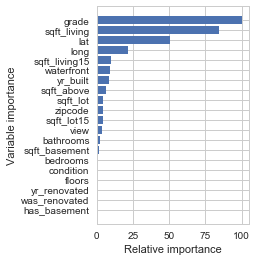

In [49]:
# Lets increase the number of iterations to 500 and take away max_depth
ranfor_reg(rfr_var, df['price'], 500, None, 5)

In [50]:
# Lets see how a logistic regression works 
from sklearn.linear_model import LogisticRegression

# First lets create another function for our logistic regression model
def logreg_sklearn(X, y, pen, cvk):
    X = StandardScaler().fit_transform(X)
    lr = LogisticRegression(penalty=pen, multi_class='multinomial')
    lr_fit = lr.fit(X,y)
    lr_predict = lr.predict(X)
    lr_score = lr.score(X,y)
    print('\nR-squared Log Regression: \n', lr_score)
    lr_crossval = cross_val_score(lr, X, y, cv=cvk)
    print('\nCross-Validation R-squared: \n', lr_crossval)
    print('\nMean Accuracy: %0.2f (+/- %0.2f)' % (lr_crossval.mean(), lr_crossval.std() * 2))

In [51]:
# Now lets define the function arguments and run the model
lr_var = df.drop(['price', 'id', 'date'], axis=1)

In [52]:
# Lets make a ridge regression

from sklearn.linear_model import RidgeCV

# Let make a function for out ridge regression model
def ridge_regcv(X, y, alph, cvk):
    rcv = RidgeCV(alphas=alph, cv=cvk)
    rcv_fit = rcv.fit(X,y)
    rcv_predict = rcv.predict(X)
    rcv_score = rcv.score(X,y)
    print('\nR-squared Ridge Reg: \n', rcv_score)

In [53]:
rcv_var = df.drop(['price', 'id', 'date'], axis=1)

ridge_regcv(rcv_var, df['price'], [0.1, 1.0, 10], 5)


R-squared Ridge Reg: 
 0.700300006071


In [54]:
# Lets try a lasso regression

from sklearn.linear_model import LassoCV

# Make a function for our lasso regression model
def lasso_regcv(X, y, nalph, cvk):
    X = StandardScaler().fit_transform(X)
    lass = LassoCV(n_alphas=nalph, cv=cvk)
    lass_fit = lass.fit(X,y)
    lass_predict = lass.predict(X)
    lass_score = lass.score(X,y)
    print('\nR-squared Lasso Reg: \n', lass_score)


In [55]:
lass_var = df.drop(['price', 'id', 'date'], axis=1)

lasso_regcv(lass_var, df['price'], 100, 5)


R-squared Lasso Reg: 
 0.699648327147


In [56]:
# Now lets try a support vector regression (SVR)

from sklearn.svm import SVR

# Make a function for our SVR model
def svr_reg(X, y, kern):
    svr = SVR(kernel=kern)
    svr_fit = svr.fit(X, y)
    svr_predict = svr.predict(X)
    svr_score = svr.score(X, y)
    print('\nR-squared SVR: \n', svr_score)

In [57]:
svr_var = df.drop(['price', 'id', 'date'], axis=1)

In [58]:
# Now lets make a gradient boosting regressor model

from sklearn.ensemble import GradientBoostingRegressor

# Lets make a function for our gradient boosting regressor
def gbr_reg(X, y, los, n_est, max_dep, subsamp, cvk):
    gbr = GradientBoostingRegressor(loss=los, n_estimators=n_est, max_depth=max_dep, subsample=subsamp)
    gbr_fit = gbr.fit(X, y)
    gbr_predict = gbr.predict(X)
    gbr_score = gbr.score(X,y)
    print('\nR-squared Gradient Boosting Reg: \n', gbr_score)
    gbr_crossval = cross_val_score(gbr, X, y, cv=cvk)
    print('\nCross-validated R-squares: \n', gbr_crossval)
    print('\nMean Accuracy: %0.2f (+/- %0.2f)' % (gbr_crossval.mean(), gbr_crossval.std() * 2))
    # Make importances relative to max importance
    feature_importance = gbr.feature_importances_
    feature_importance = 100 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) +  0.5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X.columns[sorted_idx])
    plt.xlabel('Relative importance')
    plt.ylabel('Variable importance')
    plt.show()


R-squared Gradient Boosting Reg: 
 0.907554854733

Cross-validated R-squares: 
 [ 0.88200751  0.87275392  0.86013678  0.84973132  0.8624528 ]

Mean Accuracy: 0.87 (+/- 0.02)


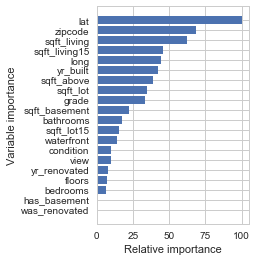

In [59]:
# Define our predictor variables
gbr_var = df.drop(['price', 'id', 'date'], axis=1)

# Define the function arguments; lets try a loss: least squared, 500 iterations, max depth of trees=2, subsample=1.0, 
# and 5 folds for cross-validation.
gbr_reg(gbr_var, df['price'], 'ls', 500, 2, 1.0, 5)


R-squared Gradient Boosting Reg: 
 0.857652979074

Cross-validated R-squares: 
 [ 0.84449181  0.82779542  0.85308561  0.8399667   0.84484292]

Mean Accuracy: 0.84 (+/- 0.02)


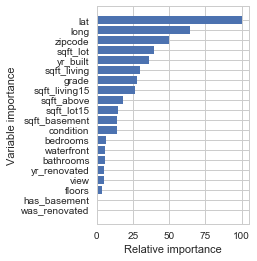

In [60]:
# Lets run another grb, but this time with the loss: least absolute deviation and all other arguments being the same.
gbr_reg(gbr_var, df['price'], 'lad', 500, 2, 1.0, 5)


R-squared Gradient Boosting Reg: 
 0.891869522941

Cross-validated R-squares: 
 [ 0.87481057  0.8598369   0.85309099  0.8576173   0.85892757]

Mean Accuracy: 0.86 (+/- 0.01)


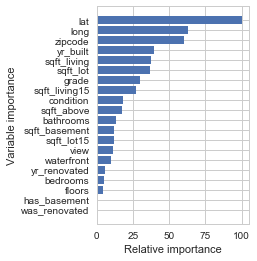

In [61]:
# Loss: lad was less accurate.  Lets try huber and see how that works.
gbr_reg(gbr_var, df['price'], 'huber', 500, 2, 1.0, 5)


R-squared Gradient Boosting Reg: 
 0.713656427769

Cross-validated R-squares: 
 [ 0.73142426  0.70232514  0.61691114  0.64706101  0.67770224]

Mean Accuracy: 0.68 (+/- 0.08)


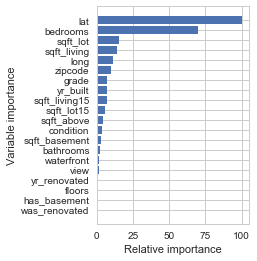

In [62]:
# Now lets change the loss to quantile.  
gbr_reg(gbr_var, df['price'], 'quantile', 500, 2, 1.0, 5)


R-squared Gradient Boosting Reg: 
 0.940318340217

Cross-validated R-squares: 
 [ 0.89655831  0.89186697  0.88574515  0.87996005  0.87817259]

Mean Accuracy: 0.89 (+/- 0.01)


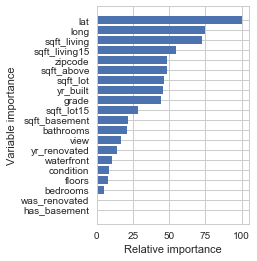

In [63]:
# Now lets mess around with the max_depth.  Lets increase it to 3 for out top gbr models and see how it works.
gbr_reg(gbr_var, df['price'], 'ls', 500, 3, 1.0, 5)


R-squared Gradient Boosting Reg: 
 0.926091553154

Cross-validated R-squares: 
 [ 0.90424981  0.88799762  0.88238694  0.88319661  0.87653032]

Mean Accuracy: 0.89 (+/- 0.02)


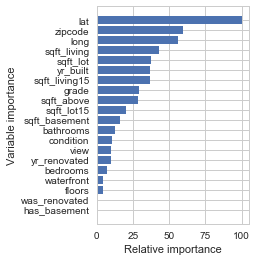

In [64]:
gbr_reg(gbr_var, df['price'], 'huber', 500, 3, 1.0, 5)


R-squared Gradient Boosting Reg: 
 0.900507893998

Cross-validated R-squares: 
 [ 0.88052464  0.86557932  0.84322991  0.85028886  0.85261648]

Mean Accuracy: 0.86 (+/- 0.03)


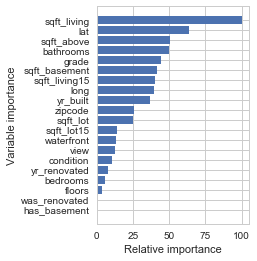

In [65]:
# Now lets change our subsample to <1 so that it results in stochastic gradient boosting.
gbr_reg(gbr_var, df['price'], 'ls', 500, 2, 0.35, 5)


R-squared Gradient Boosting Reg: 
 0.895914456413

Cross-validated R-squares: 
 [ 0.88398112  0.86478501  0.86207624  0.85012877  0.85787402]

Mean Accuracy: 0.86 (+/- 0.02)


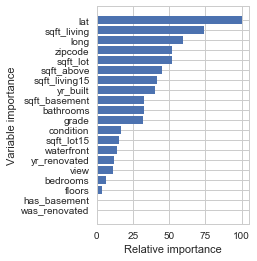

In [66]:
gbr_reg(gbr_var, df['price'], 'huber', 500, 2, 0.35, 5)


R-squared Gradient Boosting Reg: 
 0.973776510193

Cross-validated R-squares: 
 [ 0.89780314  0.89785444  0.90020754  0.8949702   0.87987057]

Mean Accuracy: 0.89 (+/- 0.01)


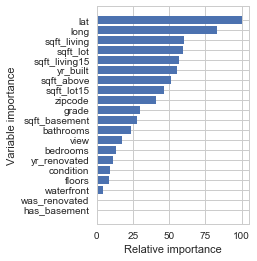

In [67]:
# Its seems the most accurate gbr model had loss:ls, 500 iterations, max_depth=3, and not stochastic gradient boosting.
# Lets increase max_depth to 5 and see how that affects the model.
gbr_reg(gbr_var, df['price'], 'ls', 500, 5, 1.0, 5)


R-squared Gradient Boosting Reg: 
 0.925844933443

Cross-validated R-squares: 
 [ 0.9004416   0.88588832  0.88223739  0.88379612  0.87689619]

Mean Accuracy: 0.89 (+/- 0.02)


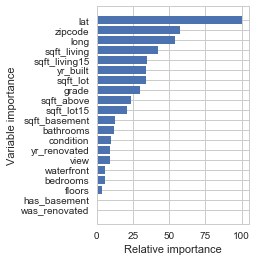

In [68]:
gbr_reg(gbr_var, df['price'], 'huber', 500, 3, 1.0, 5)

In [69]:
import gmplot


In [70]:
gmap = gmplot.GoogleMapPlotter(37.428, -122.145, 16)

gmap.draw("mymap.html")

In [74]:
gmap.scatter(df['lat'], df['long'], '#3B0B39', size=40, marker=False)

AttributeError: 'GoogleMapPlotter' object has no attribute 'show'